# Dense neural network with Keras
Author: Javier Duarte

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.root'
filename['bkg'] = 'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [2]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [3]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

## Run training 
Here, we run the training.

In [4]:
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=1024, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)

Train on 12442 samples, validate on 4148 samples
Epoch 1/1000
12442/12442 [==============================] - 0s 19us/step - loss: 0.6815 - acc: 0.8730 - val_loss: 0.6765 - val_acc: 0.9359
Epoch 2/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.6728 - acc: 0.9351 - val_loss: 0.6679 - val_acc: 0.9349
Epoch 3/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.6642 - acc: 0.9350 - val_loss: 0.6595 - val_acc: 0.9351
Epoch 4/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.6559 - acc: 0.9351 - val_loss: 0.6513 - val_acc: 0.9349
Epoch 5/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.6478 - acc: 0.9341 - val_loss: 0.6433 - val_acc: 0.9349
Epoch 6/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.6399 - acc: 0.9336 - val_loss: 0.6355 - val_acc: 0.9344
Epoch 7/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.6322 - acc: 0.9333 - val_loss: 0.6279 - 

12442/12442 [==============================] - 0s 3us/step - loss: 0.4003 - acc: 0.9275 - val_loss: 0.3981 - val_acc: 0.9270
Epoch 60/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3978 - acc: 0.9275 - val_loss: 0.3956 - val_acc: 0.9270
Epoch 61/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3954 - acc: 0.9275 - val_loss: 0.3932 - val_acc: 0.9267
Epoch 62/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3929 - acc: 0.9275 - val_loss: 0.3907 - val_acc: 0.9267
Epoch 63/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3906 - acc: 0.9274 - val_loss: 0.3884 - val_acc: 0.9267
Epoch 64/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3882 - acc: 0.9273 - val_loss: 0.3860 - val_acc: 0.9267
Epoch 65/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.3860 - acc: 0.9272 - val_loss: 0.3838 - val_acc: 0.9265
Epoch 66/1000
12442/12442 [==============

Epoch 118/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.3040 - acc: 0.9293 - val_loss: 0.3013 - val_acc: 0.9289
Epoch 119/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.3030 - acc: 0.9294 - val_loss: 0.3003 - val_acc: 0.9289
Epoch 120/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.3019 - acc: 0.9294 - val_loss: 0.2993 - val_acc: 0.9289
Epoch 121/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.3009 - acc: 0.9294 - val_loss: 0.2982 - val_acc: 0.9291
Epoch 122/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2999 - acc: 0.9294 - val_loss: 0.2972 - val_acc: 0.9291
Epoch 123/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2990 - acc: 0.9295 - val_loss: 0.2962 - val_acc: 0.9291
Epoch 124/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2980 - acc: 0.9296 - val_loss: 0.2952 - val_acc: 0.9291
Epoch 125/1000
12442

12442/12442 [==============================] - 0s 3us/step - loss: 0.2598 - acc: 0.9326 - val_loss: 0.2563 - val_acc: 0.9344
Epoch 177/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2593 - acc: 0.9326 - val_loss: 0.2557 - val_acc: 0.9342
Epoch 178/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2587 - acc: 0.9326 - val_loss: 0.2552 - val_acc: 0.9342
Epoch 179/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2582 - acc: 0.9327 - val_loss: 0.2546 - val_acc: 0.9344
Epoch 180/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2577 - acc: 0.9327 - val_loss: 0.2541 - val_acc: 0.9344
Epoch 181/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2571 - acc: 0.9328 - val_loss: 0.2535 - val_acc: 0.9344
Epoch 182/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2566 - acc: 0.9328 - val_loss: 0.2530 - val_acc: 0.9344
Epoch 183/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 2us/step - loss: 0.2348 - acc: 0.9369 - val_loss: 0.2304 - val_acc: 0.9390
Epoch 235/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2345 - acc: 0.9369 - val_loss: 0.2300 - val_acc: 0.9390
Epoch 236/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2342 - acc: 0.9371 - val_loss: 0.2297 - val_acc: 0.9392
Epoch 237/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2339 - acc: 0.9371 - val_loss: 0.2293 - val_acc: 0.9392
Epoch 238/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2335 - acc: 0.9372 - val_loss: 0.2290 - val_acc: 0.9395
Epoch 239/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2332 - acc: 0.9374 - val_loss: 0.2286 - val_acc: 0.9395
Epoch 240/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2329 - acc: 0.9376 - val_loss: 0.2283 - val_acc: 0.9395
Epoch 241/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 2us/step - loss: 0.2193 - acc: 0.9409 - val_loss: 0.2139 - val_acc: 0.9426
Epoch 293/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2191 - acc: 0.9410 - val_loss: 0.2137 - val_acc: 0.9426
Epoch 294/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2189 - acc: 0.9410 - val_loss: 0.2134 - val_acc: 0.9426
Epoch 295/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2187 - acc: 0.9410 - val_loss: 0.2132 - val_acc: 0.9426
Epoch 296/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2185 - acc: 0.9411 - val_loss: 0.2130 - val_acc: 0.9426
Epoch 297/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2183 - acc: 0.9412 - val_loss: 0.2128 - val_acc: 0.9426
Epoch 298/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2181 - acc: 0.9413 - val_loss: 0.2125 - val_acc: 0.9426
Epoch 299/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 2us/step - loss: 0.2093 - acc: 0.9437 - val_loss: 0.2030 - val_acc: 0.9453
Epoch 351/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2092 - acc: 0.9437 - val_loss: 0.2028 - val_acc: 0.9455
Epoch 352/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2090 - acc: 0.9437 - val_loss: 0.2027 - val_acc: 0.9455
Epoch 353/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2089 - acc: 0.9437 - val_loss: 0.2025 - val_acc: 0.9458
Epoch 354/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2088 - acc: 0.9437 - val_loss: 0.2024 - val_acc: 0.9458
Epoch 355/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2086 - acc: 0.9437 - val_loss: 0.2022 - val_acc: 0.9458
Epoch 356/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2085 - acc: 0.9437 - val_loss: 0.2021 - val_acc: 0.9458
Epoch 357/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.2029 - acc: 0.9453 - val_loss: 0.1956 - val_acc: 0.9484
Epoch 409/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2028 - acc: 0.9454 - val_loss: 0.1955 - val_acc: 0.9486
Epoch 410/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2027 - acc: 0.9454 - val_loss: 0.1954 - val_acc: 0.9486
Epoch 411/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.2026 - acc: 0.9454 - val_loss: 0.1953 - val_acc: 0.9486
Epoch 412/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2025 - acc: 0.9454 - val_loss: 0.1952 - val_acc: 0.9486
Epoch 413/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2024 - acc: 0.9454 - val_loss: 0.1951 - val_acc: 0.9486
Epoch 414/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.2023 - acc: 0.9454 - val_loss: 0.1950 - val_acc: 0.9486
Epoch 415/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 2us/step - loss: 0.1988 - acc: 0.9470 - val_loss: 0.1908 - val_acc: 0.9496
Epoch 467/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.1988 - acc: 0.9470 - val_loss: 0.1907 - val_acc: 0.9496
Epoch 468/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.1987 - acc: 0.9471 - val_loss: 0.1906 - val_acc: 0.9496
Epoch 469/1000
12442/12442 [==============================] - 0s 2us/step - loss: 0.1987 - acc: 0.9471 - val_loss: 0.1906 - val_acc: 0.9496
Epoch 470/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1986 - acc: 0.9471 - val_loss: 0.1905 - val_acc: 0.9496
Epoch 471/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1986 - acc: 0.9471 - val_loss: 0.1904 - val_acc: 0.9496
Epoch 472/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1985 - acc: 0.9471 - val_loss: 0.1904 - val_acc: 0.9496
Epoch 473/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.1964 - acc: 0.9478 - val_loss: 0.1876 - val_acc: 0.9496
Epoch 525/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1964 - acc: 0.9478 - val_loss: 0.1876 - val_acc: 0.9496
Epoch 526/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1964 - acc: 0.9478 - val_loss: 0.1875 - val_acc: 0.9496
Epoch 527/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1963 - acc: 0.9478 - val_loss: 0.1875 - val_acc: 0.9496
Epoch 528/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1963 - acc: 0.9478 - val_loss: 0.1874 - val_acc: 0.9496
Epoch 529/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1963 - acc: 0.9478 - val_loss: 0.1874 - val_acc: 0.9496
Epoch 530/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1963 - acc: 0.9478 - val_loss: 0.1874 - val_acc: 0.9496
Epoch 531/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.1951 - acc: 0.9485 - val_loss: 0.1857 - val_acc: 0.9503
Epoch 583/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1951 - acc: 0.9485 - val_loss: 0.1857 - val_acc: 0.9503
Epoch 584/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1951 - acc: 0.9484 - val_loss: 0.1857 - val_acc: 0.9503
Epoch 585/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1951 - acc: 0.9484 - val_loss: 0.1856 - val_acc: 0.9503
Epoch 586/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1951 - acc: 0.9483 - val_loss: 0.1856 - val_acc: 0.9501
Epoch 587/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1950 - acc: 0.9483 - val_loss: 0.1856 - val_acc: 0.9501
Epoch 588/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1950 - acc: 0.9483 - val_loss: 0.1856 - val_acc: 0.9501
Epoch 589/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9487 - val_loss: 0.1846 - val_acc: 0.9506
Epoch 641/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9487 - val_loss: 0.1846 - val_acc: 0.9506
Epoch 642/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9487 - val_loss: 0.1845 - val_acc: 0.9506
Epoch 643/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9487 - val_loss: 0.1845 - val_acc: 0.9506
Epoch 644/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9487 - val_loss: 0.1845 - val_acc: 0.9506
Epoch 645/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9488 - val_loss: 0.1845 - val_acc: 0.9503
Epoch 646/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1945 - acc: 0.9488 - val_loss: 0.1845 - val_acc: 0.9503
Epoch 647/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.1840 - val_acc: 0.9511
Epoch 699/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.1840 - val_acc: 0.9511
Epoch 700/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9491 - val_loss: 0.1840 - val_acc: 0.9511
Epoch 701/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9491 - val_loss: 0.1840 - val_acc: 0.9511
Epoch 702/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.1840 - val_acc: 0.9511
Epoch 703/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.1839 - val_acc: 0.9511
Epoch 704/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1942 - acc: 0.9492 - val_loss: 0.1839 - val_acc: 0.9513
Epoch 705/1000
12442/12442 [=======

12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 757/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 758/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 759/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 760/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 761/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 762/1000
12442/12442 [==============================] - 0s 3us/step - loss: 0.1941 - acc: 0.9495 - val_loss: 0.1836 - val_acc: 0.9513
Epoch 763/1000
12442/12442 [=======

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

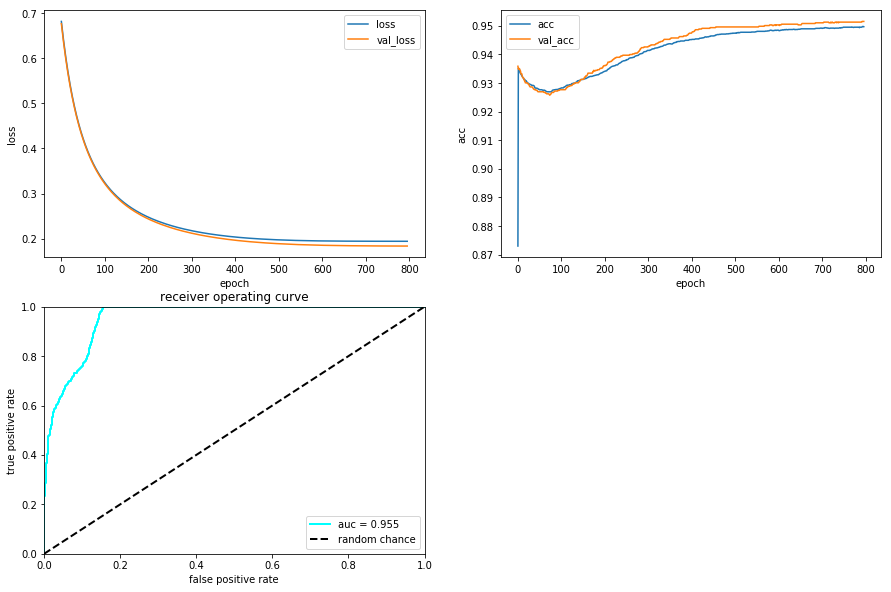

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

In [6]:
df_all['dense'] = model.predict(X) # add prediction to array
print df_all.iloc[:5]

     f_mass4l     f_massjj  isSignal  dense
0  125.077103  1300.426880       1.0    1.0
1  124.238113   437.221863       1.0    1.0
3  124.480667  1021.744080       1.0    1.0
4  124.919464  1101.381958       1.0    1.0
7  125.049065   498.717194       1.0    1.0


# Plot NN output vs input variables
Here, we will plot the NN output and devision boundary as a function of the input variables.

**Question 1:** How can we fill the correct numpy arrays for plotting?

In [7]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        #myZI[i,j] = ??? # change this

myZI = model.predict(np.c_[myXI.ravel(), myYI.ravel()])
myZI = myZI.reshape(myXI.shape)

(200, 200)


**Question 2:** The code below shows how to plot the NN output. How can we plot the NN decision boundary?

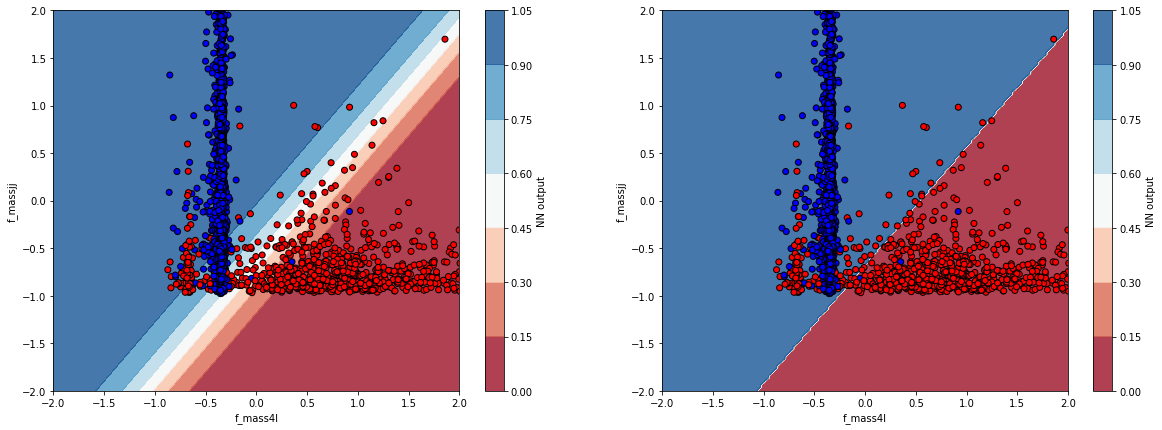

In [8]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

**Question 3:** What happens if you increase/decrease the number of hidden layers?

**Question 4:** What happens if you increase/decrease the number of nodes per hidden layer?

**Question 5:** What happens if you add/remove dropout?

**Question 6:** What happens if you add/remove early stopping?

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [9]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

Welcome to JupyROOT 6.14/04
